# EDA


## Library Imports

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import time

## Data Imports

In [121]:
#train data
data = pd.read_csv('../raw_data/dengue_features_train.csv')
labels = pd.read_csv('../raw_data/dengue_labels_train.csv')
data = data.merge(labels)
print(data.shape)

#test data
test_data = pd.read_csv('../raw_data/dengue_features_test.csv')
print(test_data.shape)

(1456, 25)
(416, 24)


In [122]:
data

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


## Functions

In [123]:
def reg_metrics(y_train, y_train_pred, y_test, y_test_pred, model='model'):
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred, multioutput='raw_values')
    metrics_df = pd.DataFrame(data = zip(test_mae, train_mae),
                              columns=['test_mae','train_mae'])
    metrics_df.index.names = [model]
    return metrics_df

## Basic data preparation and visualizations

In [124]:
#NaN count for each column
data.isnull().sum().sort_values(ascending=False)

ndvi_ne                                  194
ndvi_nw                                   52
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_precip_mm                         22
ndvi_se                                   22
ndvi_sw                                   22
station_max_temp_c                        20
station_min_temp_c                        14
precipitation_amt_mm                      13
reanalysis_sat_precip_amt_mm              13
reanalysis_relative_humidity_percent      10
reanalysis_tdtr_k                         10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_max_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
city                                       0
year                                       0
week_start

These Nan values will be tackled in preprocessing

### Splitting data into separate dataframes for both cities

In [125]:
data_sj = data.iloc[:936,:]

In [126]:
data_iq = data.iloc[936:,:]

In [127]:
print(data_iq.shape,data_sj.shape)

(520, 25) (936, 25)


In [128]:
#fix time data
data_iq['year_week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%Y-%U')
data_iq['week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%U')
data_iq['month'] = pd.DatetimeIndex(data_iq['week_start_date']).month

data_sj['year_week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%Y-%U')
data_sj['week'] = pd.to_datetime(data_sj['week_start_date']).dt.strftime('%U')
data_sj['month'] = pd.DatetimeIndex(data_sj['week_start_date']).month

/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_99638/611139066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_iq['year_week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%Y-%U')
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_99638/611139066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_iq['week'] = pd.to_datetime(data_iq['week_start_date']).dt.strftime('%U')
/var/folders/32/ctcz3rj15jg1r9xjzn1p08p40000gn/T/ipykernel_99638/611139066.py:4: SettingWith

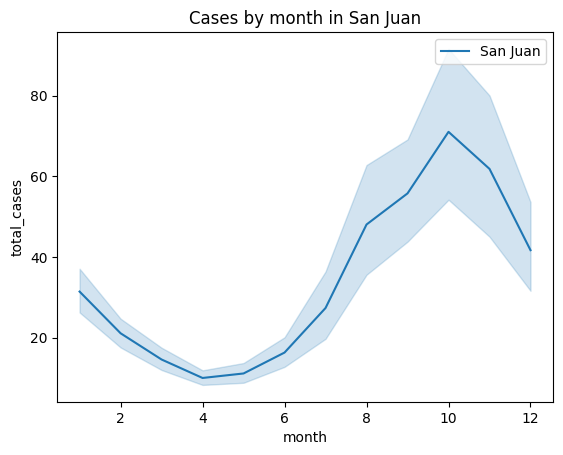

In [129]:
plt.title('Cases by month in San Juan')
sns.lineplot(data=data_sj,x='month',y='total_cases',label='San Juan')
plt.show;

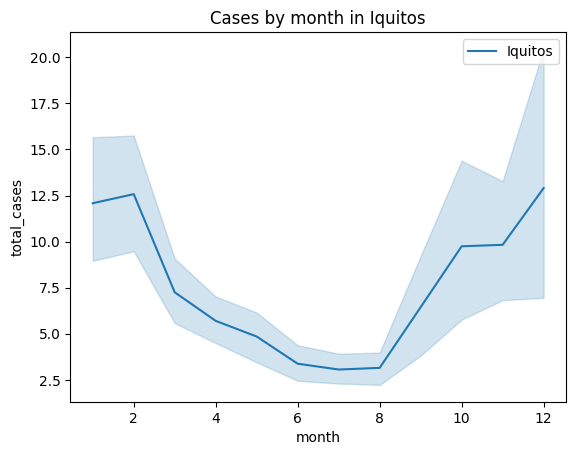

In [130]:
plt.title('Cases by month in Iquitos')
sns.lineplot(data=data_iq,x='month',y='total_cases',label='Iquitos')
plt.show;

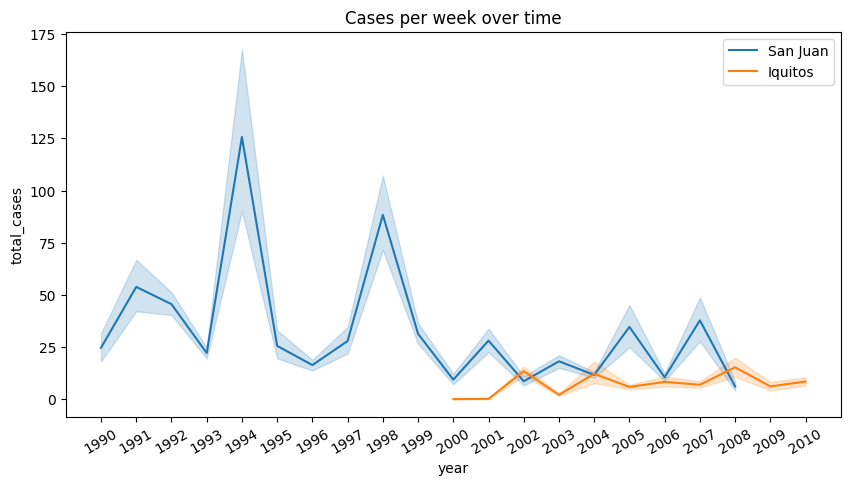

In [273]:
plt.figure(figsize=(10, 5))
plt.title('Cases per week over time')
sns.lineplot(data=data_sj,x='year',y='total_cases',label='San Juan')
sns.lineplot(data=data_iq,x='year',y='total_cases',label='Iquitos')
plt.xticks(np.arange(1990, 2011, step=1),rotation=30)
plt.legend()
plt.show;

## Preprocessing San Juan

In [384]:
def preprocess_sj(rawfeats,train=True):
    
    #fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    
    new_columns = pd.DataFrame()
    #scale and average total precipitation
    precipitation_to_avg = feats.loc[:,['reanalysis_sat_precip_amt_mm','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2']]
    scaled_precip = pd.DataFrame(MinMaxScaler().fit_transform(precipitation_to_avg), 
                                columns=precipitation_to_avg.columns)
    new_columns.loc[:,'avg_total_precipitation'] = scaled_precip.mean(axis=1)
    
    #scale and average temperature
    temps_to_avg = feats.loc[:,['reanalysis_air_temp_k','reanalysis_avg_temp_k','station_avg_temp_c']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(temps_to_avg), 
                                columns=temps_to_avg.columns)
    new_columns.loc[:,'avg_temp'] = scaled_temps.mean(axis=1)
    
    #scale and average max temperature
    max_temps_to_avg = feats.loc[:,['station_max_temp_c','reanalysis_max_air_temp_k']]
    scaled_max_temps = pd.DataFrame(MinMaxScaler().fit_transform(max_temps_to_avg), 
                                columns=max_temps_to_avg.columns)
    new_columns.loc[:,'avg_max_temp'] = scaled_max_temps.mean(axis=1)
    
    #scale and average min temperature
    min_temps_to_avg = feats.loc[:,['station_min_temp_c','reanalysis_min_air_temp_k']]
    scaled_min_temps = pd.DataFrame(MinMaxScaler().fit_transform(min_temps_to_avg), 
                                columns=min_temps_to_avg.columns)
    new_columns.loc[:,'avg_min_temp'] = scaled_min_temps.mean(axis=1)
    
    #scale and average diurnal temperature
    diurnal_temps_to_avg = feats.loc[:,['station_diur_temp_rng_c','reanalysis_tdtr_k']]
    scaled_diurnal_temps = pd.DataFrame(MinMaxScaler().fit_transform(diurnal_temps_to_avg), 
                                columns=diurnal_temps_to_avg.columns)
    new_columns.loc[:,'avg_diurnal_temp'] = scaled_diurnal_temps.mean(axis=1)
    
    #scale humidity and dew point data
    remaining_feats_to_scale = feats.loc[:,['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_dew_point_temp_k']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    df = new_columns.join(scaled_feats)
    
    #add shifted features, 4 weeks
    to_shift = ['avg_max_temp','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','avg_total_precipitation','reanalysis_dew_point_temp_k','avg_min_temp'] 
    for i in to_shift:
        df[i+'_1lag'] = df[i].shift(-1)
        df[i+'_2lag'] = df[i].shift(-2)
        df[i+'_3lag'] = df[i].shift(-3)
        df[i+'_4lag'] = df[i].shift(-4)
    df = df.fillna(method='ffill')
    
    #merge back together
    non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw','total_cases']]
    
    final_df = df.join(non_scaled_feats)
    
    return final_df

## Preprocessing Iquitos

In [385]:
def preprocess_iq(rawfeats,train=True):
    
    #fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')
    
    #scale feats
    remaining_feats_to_scale = feats.loc[:,['precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']]
    scaled_feats = pd.DataFrame(MinMaxScaler().fit_transform(remaining_feats_to_scale), 
                                columns=remaining_feats_to_scale.columns)
    
    #add shifted features, 3 weeks
    to_shift = ['reanalysis_min_air_temp_k','station_max_temp_c','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2','reanalysis_dew_point_temp_k'] 
    for i in to_shift:
        scaled_feats[i+'_1lag'] = scaled_feats[i].shift(-1)
        scaled_feats[i+'_2lag'] = scaled_feats[i].shift(-2)
        scaled_feats[i+'_3lag'] = scaled_feats[i].shift(-3)
        scaled_feats[i+'_4lag'] = scaled_feats[i].shift(-4)
    scaled_feats = scaled_feats.fillna(method='ffill')
    
    #merge back together
    non_scaled_feats = feats[['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw','total_cases']]
    
    df = scaled_feats.join(non_scaled_feats)
    
    return df

In [389]:
iq_data = preprocess_iq(data_iq)
sj_data = preprocess_sj(data_sj)
sj_data

,avg_total_precipitation,avg_temp,avg_max_temp,avg_min_temp,avg_diurnal_temp,reanalysis_specific_humidity_g_per_kg,reanalysis_relative_humidity_percent,reanalysis_dew_point_temp_k,avg_max_temp_1lag,avg_max_temp_2lag,...,reanalysis_dew_point_temp_k_4lag,avg_min_temp_1lag,avg_min_temp_2lag,avg_min_temp_3lag,avg_min_temp_4lag,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,total_cases
0,0.042998,0.296626,0.305532,0.367053,0.427136,0.297392,0.318138,0.339933,0.519360,0.516681,...,0.757841,0.542325,0.642431,0.653934,0.726642,0.122600,0.103725,0.198483,0.177617,4
1,0.044101,0.427818,0.519360,0.542325,0.336204,0.473460,0.510214,0.528474,0.516681,0.647710,...,0.761521,0.642431,0.653934,0.726642,0.767738,0.169900,0.142175,0.162357,0.155486,5
2,0.089486,0.482169,0.516681,0.642431,0.335186,0.664509,0.734988,0.710356,0.647710,0.781677,...,0.763273,0.653934,0.726642,0.767738,0.701879,0.032250,0.172967,0.157200,0.170843,4
3,0.029022,0.547318,0.647710,0.653934,0.382641,0.641761,0.652660,0.695111,0.781677,0.786430,...,0.844927,0.726642,0.767738,0.701879,0.717773,0.128633,0.245067,0.227557,0.235886,3
4,0.019713,0.667468,0.781677,0.726642,0.719370,0.711300,0.658555,0.757841,0.786430,0.578220,...,0.826178,0.767738,0.701879,0.717773,0.669828,0.196200,0.262200,0.251200,0.247340,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.039585,0.202188,0.331547,0.334826,0.365548,0.249676,0.360433,0.300859,0.372947,0.274762,...,0.568775,0.549175,0.469178,0.476027,0.578591,0.077850,-0.039900,0.310471,0.296243,4
932,0.006907,0.387352,0.372947,0.549175,0.433132,0.381542,0.377365,0.440687,0.274762,0.297839,...,0.568775,0.469178,0.476027,0.578591,0.578591,-0.038000,-0.016833,0.119371,0.066386,3
933,0.062138,0.260358,0.274762,0.469178,0.244963,0.319586,0.397861,0.379008,0.297839,0.519360,...,0.568775,0.476027,0.578591,0.578591,0.578591,-0.155200,-0.052750,0.137757,0.141214,1
934,0.011266,0.295707,0.297839,0.476027,0.391709,0.277418,0.266315,0.322762,0.519360,0.519360,...,0.568775,0.578591,0.578591,0.578591,0.578591,0.001800,-0.031558,0.203900,0.209843,3


In [387]:
print(iq_data.shape,sj_data.shape)

(520, 45) (936, 37)


## A look at correlations

In [340]:
# compute the correlations
sj_correlations = sj_data.corr()
iq_correlations = iq_data.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

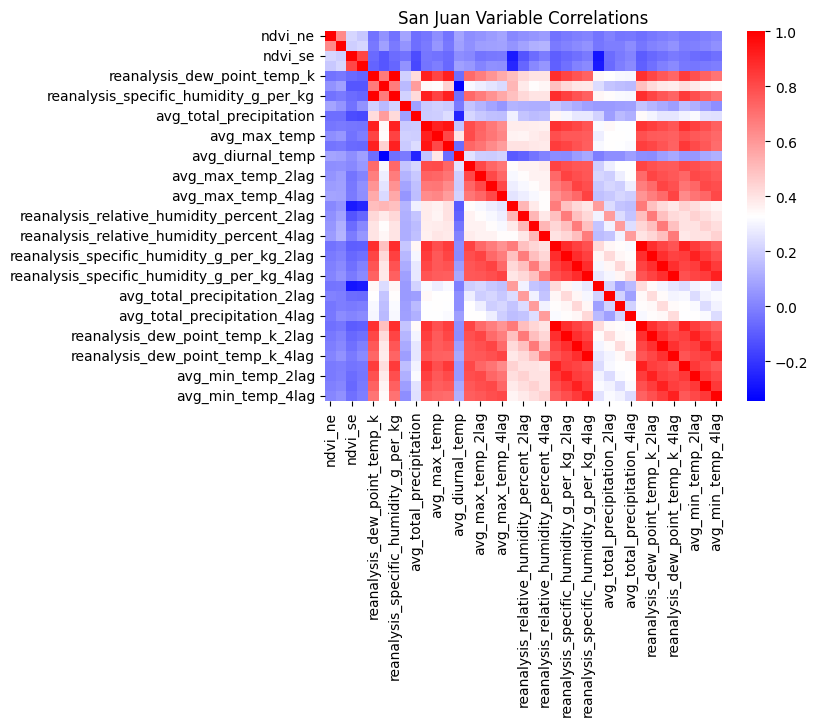

In [341]:
# plot san juan
sj_heatmap = sns.heatmap(sj_correlations,cmap= "bwr")
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

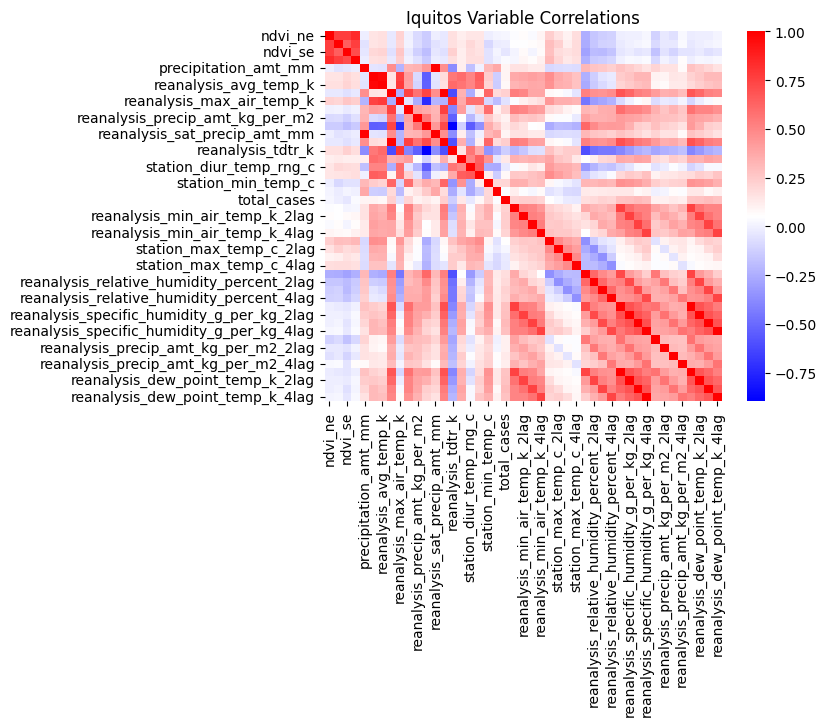

In [342]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap= "bwr")
plt.title('Iquitos Variable Correlations')

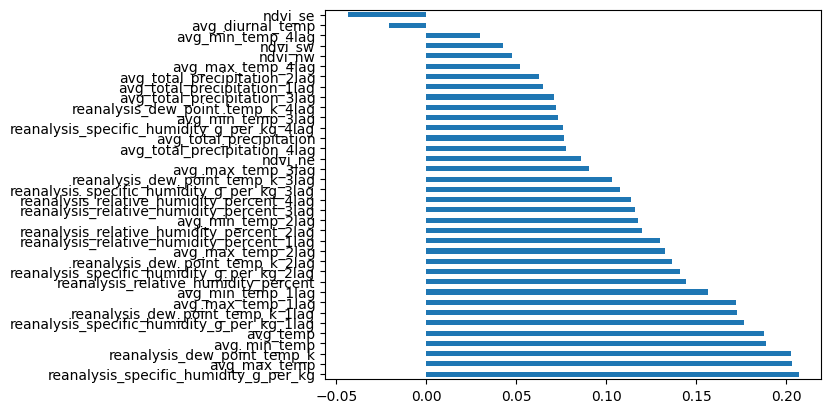

In [343]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

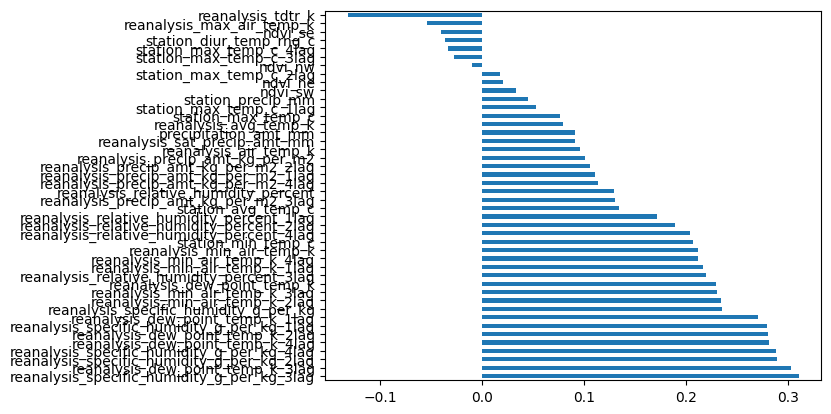

In [344]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

## Baseline model to beat

In [345]:
#Baseline mae to beat for San Juan
abs(data_sj['total_cases']-(data_sj['total_cases'].mean())).mean()

28.352089268755936

In [346]:
#Baseline mae to beat for Iquitos
abs(data_iq['total_cases']-(data_iq['total_cases'].mean())).mean()

6.684008875739645

## Modeling

In [347]:
iq_X = iq_data.drop(['total_cases'], axis=1)
iq_y = iq_data.total_cases

iq_X_train = iq_X.head(490)
iq_X_test = iq_X.tail(130)
iq_y_train = iq_y.head(490)
iq_y_test = iq_y.tail(130)

print(iq_X_train.shape)
print(iq_X_test.shape)

(490, 44)
(130, 44)


In [348]:
sj_X = sj_data.drop(['total_cases'], axis=1)
sj_y = sj_data.total_cases

sj_X_train = sj_X.head(702)
sj_X_test = sj_X.tail(234)
sj_y_train = sj_y.head(702)
sj_y_test = sj_y.tail(234)

print(sj_X_train.shape)
print(sj_X_test.shape)

(702, 36)
(234, 36)


### ADF test for stationarity

In [349]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_sj["total_cases"])[1])

p-value:  5.1473186737591e-09


In [350]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_iq["total_cases"])[1])

p-value:  1.0672522948401663e-07


### Random Forest

In [280]:
#Define the parameters we want to use for the Grid Search
param_grid = {
    'max_depth': [5,15,None],
    'warm_start': [True, False],
    'max_features': [2, 5],
    'min_samples_leaf': [1,5,15],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200],
}


In [281]:
# #Grid Search SJ
# start = time.time()

# rf = RandomForestRegressor(criterion='absolute_error')
# search_rf = GridSearchCV(rf, param_grid=param_grid, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
# search_rf.fit(sj_X, sj_y);
# sj_rf_params = search_rf.best_params_
# print(search_rf.best_score_)

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

In [282]:
sj_rf_params = {'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 100,
 'warm_start': False}

In [283]:
# #Grid Search IQ
# start = time.time()

# rf = RandomForestRegressor(criterion='absolute_error')
# search_rf = GridSearchCV(rf, param_grid=param_grid, 
#                               cv=TimeSeriesSplit(n_splits=5), n_jobs=2, verbose=2, scoring='neg_mean_absolute_error')
# search_rf.fit(iq_X, iq_y);
# iq_rf_params = search_rf.best_params_
# print(search_rf.best_score_)

# executionTime = (time.time() - start)
# print("Execution time:",
#       np.round(executionTime,2)," seconds")

In [284]:
iq_rf_params = {'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100,
 'warm_start': False}

In [353]:
#Initialize models
sj_rf_model = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rf_model = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')

In [354]:
#Fitting models on training data

sj_rf_model.fit(sj_X_train, sj_y_train)

iq_rf_model.fit(iq_X_train, iq_y_train)

print('Training Complete!')

Training Complete!


In [355]:
#Making predictions on training and testing data for San Juan
sj_train_pred = sj_rf_model.predict(sj_X_train).astype(int)
sj_test_pred = sj_rf_model.predict(sj_X_test).astype(int) 

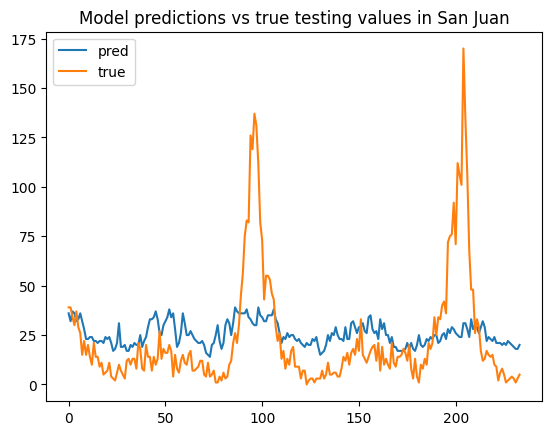

In [356]:
# plotting predictions vs testing values for San Juan
plt.plot(sj_test_pred, label='pred')
plt.plot(sj_y_test.values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in San Juan')
plt.show;

In [357]:
#Making predictions on training and testing data for Iquitos

iq_test_pred = iq_rf_model.predict(iq_X_test).astype(int)
iq_train_pred = iq_rf_model.predict(iq_X_train).astype(int)

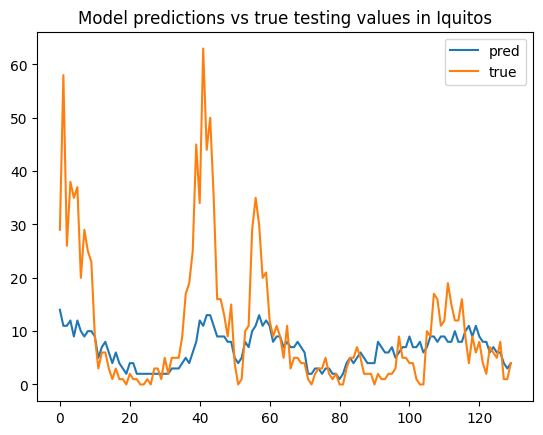

In [358]:
# plotting predictions vs testing values for Iquitos
plt.plot(iq_test_pred, label='pred')
plt.plot(iq_y_test.values, label='true')
plt.legend()
plt.title('Model predictions vs true testing values in Iquitos')
plt.show;

In [359]:
# Get training and testing metrics to check for overfitting
sj_rf_metrics = reg_metrics(sj_y_train, sj_train_pred, sj_y_test, sj_test_pred,'San Juan rf')
iq_rf_metrics = reg_metrics(iq_y_train, iq_train_pred, iq_y_test, iq_test_pred,'Iquitos rf')

sj_rf_metrics.T, iq_rf_metrics.T

(San Juan rf          0
 test_mae     18.128205
 train_mae    24.082621,
 Iquitos rf         0
 test_mae    6.423077
 train_mae   4.475510)

looks like some slight overfitting is happening for Iquitos and for San Juan the model is underfitting.

In [360]:
#concatenating training and testing predictions and values
iq_total_pred = np.hstack((iq_train_pred,iq_test_pred))
iq_true_values = np.hstack((iq_y_train.values,iq_y_test.values))

sj_total_pred = np.hstack((sj_train_pred,sj_test_pred))
sj_true_values = np.hstack((sj_y_train.values,sj_y_test.values))

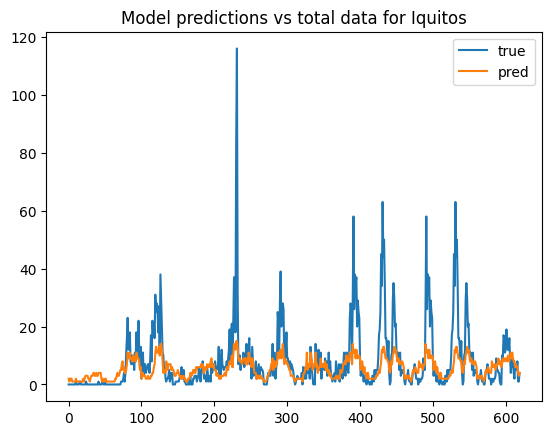

In [361]:
plt.plot(iq_true_values, label='true')
plt.plot(iq_total_pred, label='pred')
plt.legend()
plt.title('Model predictions vs total data for Iquitos')
plt.show;

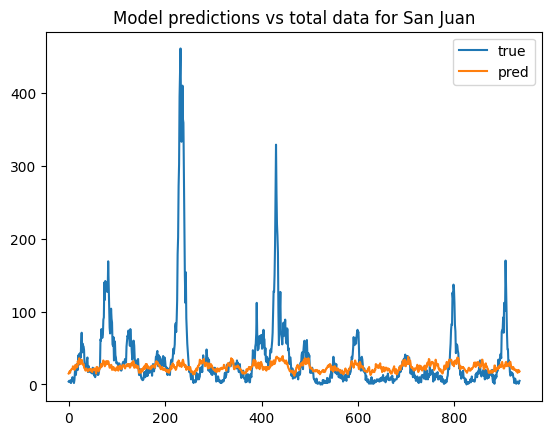

In [227]:
plt.plot(sj_true_values, label='true')
plt.plot(sj_total_pred, label='pred')
plt.legend()
plt.title('Model predictions vs total data for San Juan')
plt.show;

## Submission prediction

In [162]:
sj_rf_model.fit(sj_X, sj_y)

iq_rf_model.fit(iq_X, iq_y)

print('Training Complete!')

Training Complete!


In [163]:
testing_data = pd.read_csv('../raw_data/dengue_features_test.csv')

In [164]:
sj_test = testing_data[testing_data.city=='sj'].copy()
sj_test = preprocess_iq(sj_test,train=False)
sj_test.shape

(260, 32)

In [165]:
iq_test = testing_data[testing_data.city=='iq'].copy()
iq_test = preprocess_iq(iq_test,train=False)
#Should be 32 feat columns
iq_test.shape

(156, 32)

In [166]:
sj_pred = sj_rf_model.predict(sj_test).astype(int)
iq_pred = iq_rf_model.predict(iq_test).astype(int)

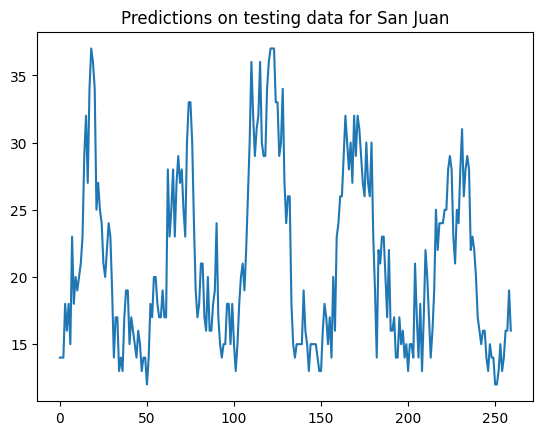

In [167]:
plt.plot(sj_pred)
plt.title('Predictions on testing data for San Juan')
plt.show;

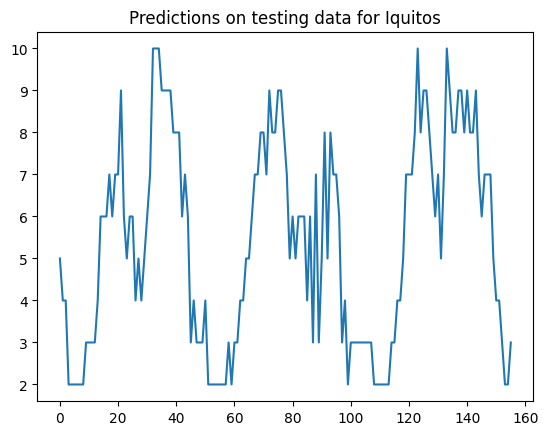

In [168]:
plt.plot(iq_pred)
plt.title('Predictions on testing data for Iquitos')
plt.show;

In [169]:
#Confirm no negative predictions
print(np.min(sj_pred))
print(np.min(iq_pred))

12
2


In [170]:
submission = pd.read_csv('../raw_data/submission_format.csv',
                            index_col=[0, 1, 2])

In [171]:
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("../submissions/rf_submission.csv")